In [1]:
# -------------------------------------------------------------------------
# Filename: main.py
#  Purpose: Main scripts to do the processing of the data
#           uses preprocessed data to calculate estimations of
#           phase velocities and backazimuths, write results
#           plotting figures, writing results to a file. Uses
#           the module "rolode" which can be found in the file "rolode.py"
#   Author: Alexander Wietek
#   Email:  alexander.wietek@mytum.de
#
# Copyright (C) 2013 Alexander Wietek
# -------------------------------------------------------------------------
#
#  I modify the main program such that we do the preprocessing via SeisHub
#  and use the results directly
#
#  Author: Joachim Wassermann (2013)
# -------------------------------------------------------------------------
#
#  I simply prettified the code and cleared some bugs for the current python3
#  version in rolode2.py
#
#  Author: Andreas Brotzer (2024)
# -------------------------------------------------------------------------

In [2]:
import os
import yaml
import numpy as np
import scipy as sp
import rochade_v3 as rochade
import pickle

from tqdm.notebook import tqdm
from obspy.signal import array_analysis as AA
from obspy import read, read_inventory, UTCDateTime, Stream
from obspy.clients.filesystem.sds import Client
from obspy.core import AttribDict
from obspy.signal.rotate import rotate2zne

#matplotlib.use('agg')

In [3]:
from functions.get_time_intervals import __get_time_intervals
from functions.get_octave_bands import __get_octave_bands


In [4]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

In [5]:
def notch(trace, f_cut):
    wn = f_cut/trace.stats.sampling_rate
    r = 0.99
    B, A = np.zeros(3), np.zeros(3)
    A[0], A[1], A[2] = 1.0, -2.0*r*np.cos(2*np.pi*wn), r*r
    B[0], B[1], B[2] = 1.0, -2.0*np.cos(2*np.pi*wn), 1.0
    trace.data = sp.signal.lfilter(B, A, trace.data, axis=0)

In [6]:
def __read_from_sds(path_to_archive, seed, tbeg, tend, data_format="MSEED"):
    """
    VARIABLES:
     - path_to_archive
     - seed
     - tbeg, tend
     - data_format

    DEPENDENCIES:
     - from obspy.core import UTCDateTime
     - from obspy.clients.filesystem.sds import Client

    OUTPUT:
     - stream

    EXAMPLE:
    >>> st = __read_sds(path_to_archive, seed, tbeg, tend, data_format="MSEED")
    """

    import os
    from obspy.core import UTCDateTime, Stream
    from obspy.clients.filesystem.sds import Client

    tbeg, tend = UTCDateTime(tbeg), UTCDateTime(tend)

    if not os.path.exists(path_to_archive):
        print(f" -> {path_to_archive} does not exist!")
        return

    ## separate seed id
    net, sta, loc, cha = seed.split(".")

    ## define SDS client
    client = Client(path_to_archive, sds_type='D', format=data_format)

    ## read waveforms
    try:
        st = client.get_waveforms(net, sta, loc, cha, tbeg, tend, merge=-1)
    except:
        print(f" -> failed to obtain waveforms!")
        st = Stream()

    return st

In [7]:
def __postprocessing(config, wave_type="love"):

    if wave_type.lower() == "love":

        # check if love waves were selected and processed
        if not config['love_waves']:
            print(f" Love waves not set in configurations")
            return
        else:
            # define path to save plots and data
            save_path = config['save_path_love']

            # specify windows file
            windows_file = "windows_l.pkl"

    elif wave_type.lower() == "rayleigh1":

        # check if love waves were selected and processed
        if not config['rayleigh1_waves']:
            print(f" Rayleigh 1 waves not set in configurations")
            return
        else:
            # define path to save plots and data
            save_path = config['save_path_rayleigh1']

            # specify windows file
            windows_file = "windows_r.pkl"

    elif wave_type.lower() == "rayleigh2":

        # check if love waves were selected and processed
        if not config['rayleigh2_waves']:
            print(f" Rayleigh 2 waves not set in configurations")
            return
        else:
            # define path to save plots and data
            save_path = config['save_path_rayleigh2']

            # specify windows file
            windows_file = "windows_r2.pkl"

    # load data
    print(f"-> load data: {save_path}{windows_file}")
    with open(save_path+windows_file, "rb") as winfile:
        windows = pickle.load(winfile)

    if config['verbose']:
        print(f"-> loaded {winfile}")

    # set windows interval
    windows.wineval = True

    # Calculate means, modes, medians, standard deviations, and set weights
    windows.set_weights(method=config['wghtmethod'], exp=config['exponent'])

    # Calculate mean and standard deviation
    try:
        windows.calc_mean_std()
    except:
        print(f"-> failed to calculate mean")
        pass

    # Calculate KDE for mode
    try:
        windows.calc_kde_mode()
    except:
        print(f"-> failed to calculate kde")
        pass

    # Calculate median
    try:
        windows.calc_median()
    except:
        print(f"-> failed to calculate median")
        pass

    # Plot all the histograms for the individual frequencies
    try:
        windows.plot_histograms(savepath=save_path)
    except:
        print(f"-> failed to plot histograms")
        pass

    # Plot the slowness and backazimuth distribution for all frequencies
    try:
        windows.plot_polar(savepath=save_path)
    except:
        print(f"-> failed to plot slowness and backazimuth distribution")
        pass

    # Plot the dispersion curves with errorbars
    try:
        windows.plot_errorbar(savepath=save_path)
    except:
        print(f"-> failed to plot dispersion curves with errorbars")
        pass

    # Write results to a file
    try:
        windows.writeresults(savepath=save_path)
    except:
        print(f"-> failed to write results")
        pass

    print(f"\n Done for {wave_type.upper()}\n")

In [8]:
def __load_rot_data(config, t1, t2):

    net, sta, loc, cha = config['rot_seed'].split(".")

    try:
        # read rotational data
        rot = __read_from_sds(config['path_to_sds_rot'], config['rot_seed'], t1-1, t2+1)
    except:
        print(f" -> loading rotation data failed!")

    if config['verbose']:
        print(rot)

    return rot

In [9]:
def __load_tra_data(config, t1, t2):

    net, sta, loc, cha = config['tra_seed'].split(".")

    try:
        # read translational data
        tra = __read_from_sds(config['path_to_sds_tra'], config['tra_seed'], t1-1, t2+1)

    except:
        print(f" -> loading translation data failed!")

    if config['verbose']:
        print(tra)

    try:
        tra = tra.detrend("linear")

        tra = tra.filter('highpass', freq=0.005, zerophase=True)

        # remove response
        # tra = tra.remove_response(config['tra_inv'], water_level=10, output=config['tra_output'])
        tra = tra.remove_response(config['tra_inv'], output=config['tra_output'])

    except:
        print(f" -> removing response failed!")

    return tra

## Configurations

In [10]:
config = {}

# Data structure has to be:
# /<STATIONNAME>/<YEAR>/<NETWORK>/<STATION>/<COMPONENT>.D/<mseed_data_files>
#
# Example: /FINM1/2023/XX/FINM1/HHZ.D/XX.FINM1..HHZ.D.2023.041

# config['client'] = Client('/home/andbro/kilauea-data/VelocityChanges/data/VROMY/sds/', sds_type='D', format='MSEED',)

config['path_to_sds_rot'] = archive_path+"temp_archive/"
config['path_to_sds_tra'] = bay_path+"mseed_online/archive/"

# specify directory for output data files
# config['path_to_outdata'] = "/home/andbro/kilauea-data/VelocityChanges/data/VROMY/"
config['path_to_outdata'] = data_path+"VelocityChanges/data/VROMY/"

# specify response information file
config['path_to_inv_tra'] = data_path+'stationxml_ringlaser/station_GR_FUR.xml' #seismometer
config['path_to_inv_rot'] = data_path+'stationxml_ringlaser/station_BW_ROMY.xml' #blueSeis

# client2 = Client("IRIS")
config['tra_seed'] = 'GR.FUR..BH*' # seed of translational data
config['rot_seed'] = 'BW.ROMY.30.BJ*' # seed of rotational data


# specify velocity limits
config['vmin'] = 50
config['vmax'] = 4500

# define start and end time of your data
config['tbeg'] = UTCDateTime("2024-09-09T00:00:00")
config['tend'] = UTCDateTime("2024-09-10T00:00:00")

# specify interval durtation and overlap
config['interval_seconds'] = 10800 # seconds
config['interval_overlap'] = 0 #0.1 # seconds


# specify translational output
config['tra_output'] = "ACC"

# select methods to compute
config['love_waves'] = True
config['rayleigh1_waves'] = False # old
config['rayleigh2_waves'] = True

config['periods_per_window'] = 8 # 8

# Specify frequency bands here
config['f_min'] = 0.01 # smallest frequency to process
config['f_max'] = 8.0 # highest frequency to process
# config['f_space'] = 0.1 # frequency steps
# config['bandwidth'] = 0.1  # Bandwidth of bandpass filter


# Set method for weighing the time windows. Can be one of
#    "standard" ... wght = np.sum(rotrate**2)/(err)
#    "normed"   ... wght = (1 - err/np.sum(rotrate**2)^exp)
#    "uniform"  ... wght = 1
config['wghtmethod'] = "normed"

# specify mask value
# mvalue = -1
config['mvalue'] = -1

# exponent of normed weights
# exp = 0.3
config['exponent'] = 0.3

# common sampling rate to resample the data
config['sampling_rate'] = 20.

# define fraction of ocatave bands
config['faction_of_octave'] = 3

# for body waves. not ripe yet
config['body'] = False

# set trigger
config['detrigger'] = False

# parameters for trigger, if detrigger = True
tsta = 1.5
tlta = 10.
thres1 = 2.8
thres2 = 0.5
pre = 2.
post = 10.

config['trigger_params'] = {"sta": tsta,"lta": tlta,"thres_1":thres1,"thres_2": thres2,"pre_t":pre,"post_t":post}

# set flag for first iteration
config['firstRun'] = True

# set if details are printed
config['verbose'] = True

# store configurations
# with open(config['path_to_sds']+'config.yml', 'w') as outfile:
#     yaml.dump(config, outfile, default_flow_style=False, sort_keys=True)


## Main Code

  0%|          | 0/8 [00:00<?, ?it/s]

6 Trace(s) in Stream:
BW.ROMY.30.BJE | 2024-09-08T23:59:59.004000Z - 2024-09-09T02:30:59.954000Z | 20.0 Hz, 181220 samples
BW.ROMY.30.BJE | 2024-09-09T02:34:00.104000Z - 2024-09-09T03:00:01.004000Z | 20.0 Hz, 31219 samples
BW.ROMY.30.BJN | 2024-09-08T23:59:59.039400Z - 2024-09-08T23:59:59.989400Z | 20.0 Hz, 20 samples
BW.ROMY.30.BJN | 2024-09-09T00:00:00.030400Z - 2024-09-09T02:30:59.930400Z | 20.0 Hz, 181199 samples
BW.ROMY.30.BJN | 2024-09-09T02:34:00.080400Z - 2024-09-09T03:00:00.980400Z | 20.0 Hz, 31219 samples
BW.ROMY.30.BJZ | 2024-09-08T23:59:59.006400Z - 2024-09-09T03:00:01.006400Z | 20.0 Hz, 216041 samples
3 Trace(s) in Stream:
GR.FUR..BHE | 2024-09-08T23:59:59.024999Z - 2024-09-09T03:00:01.024999Z | 20.0 Hz, 216041 samples
GR.FUR..BHN | 2024-09-08T23:59:59.024999Z - 2024-09-09T03:00:01.024999Z | 20.0 Hz, 216041 samples
GR.FUR..BHZ | 2024-09-08T23:59:59.024999Z - 2024-09-09T03:00:01.024999Z | 20.0 Hz, 216041 samples
6 Trace(s) in Stream:
BW.ROMY.30.BJE | 2024-09-08T23:59:59.504

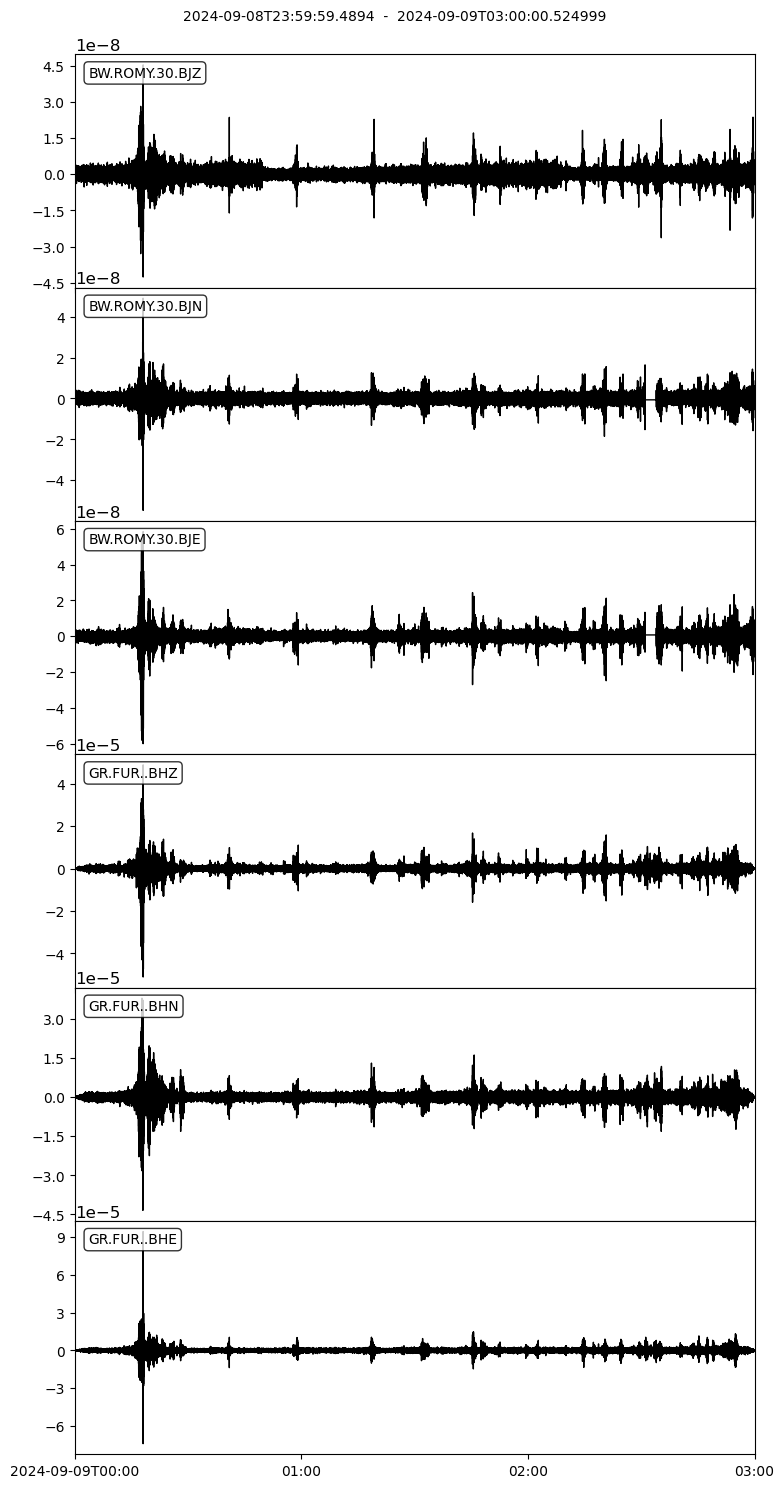

--------------------------------------------------------
ROLODE estimator class:
Parameters:
  highpass frequencies:
    [5.62341325 3.98107171 2.81838293 1.99526231 1.41253754 1.
 0.70794578 0.50118723 0.35481339 0.25118864 0.17782794 0.12589254
 0.08912509 0.06309573 0.04466836 0.03162278 0.02238721 0.01584893
 0.01122018]
  lowpass frequencies:
    [7.94328235 5.62341325 3.98107171 2.81838293 1.99526231 1.41253754
 1.         0.70794578 0.50118723 0.35481339 0.25118864 0.17782794
 0.12589254 0.08912509 0.06309573 0.04466836 0.03162278 0.02238721
 0.01584893]
  periods per window: 8.00
--------------------------------------------------------

ROLODE parameter estimation for seperate time windows

  from: Sun Sep  8 23:59:59 2024
  to:   Mon Sep  9 03:00:00 2024

  Now at frequency f = 6.69 with bandwidth df = 2.32
  Now at frequency f = 4.73 with bandwidth df = 1.64
  Now at frequency f = 3.35 with bandwidth df = 1.16
  Now at frequency f = 2.37 with bandwidth df = 0.82
  Now at freq

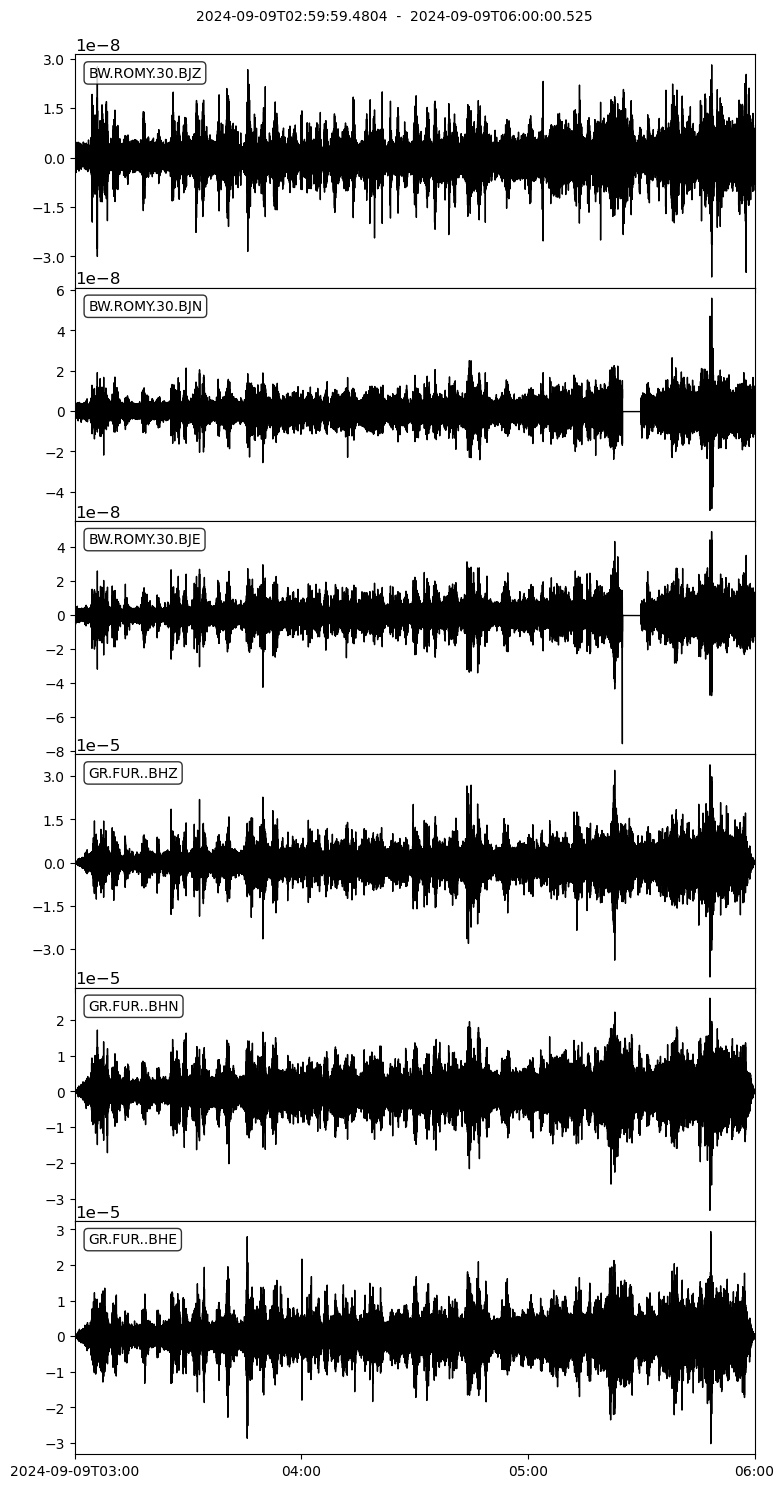

--------------------------------------------------------
ROLODE estimator class:
Parameters:
  highpass frequencies:
    [5.62341325 3.98107171 2.81838293 1.99526231 1.41253754 1.
 0.70794578 0.50118723 0.35481339 0.25118864 0.17782794 0.12589254
 0.08912509 0.06309573 0.04466836 0.03162278 0.02238721 0.01584893
 0.01122018]
  lowpass frequencies:
    [7.94328235 5.62341325 3.98107171 2.81838293 1.99526231 1.41253754
 1.         0.70794578 0.50118723 0.35481339 0.25118864 0.17782794
 0.12589254 0.08912509 0.06309573 0.04466836 0.03162278 0.02238721
 0.01584893]
  periods per window: 8.00
--------------------------------------------------------

ROLODE parameter estimation for seperate time windows

  from: Mon Sep  9 02:59:59 2024
  to:   Mon Sep  9 06:00:00 2024

  Now at frequency f = 6.69 with bandwidth df = 2.32
  Now at frequency f = 4.73 with bandwidth df = 1.64
  Now at frequency f = 3.35 with bandwidth df = 1.16
  Now at frequency f = 2.37 with bandwidth df = 0.82
  Now at freq

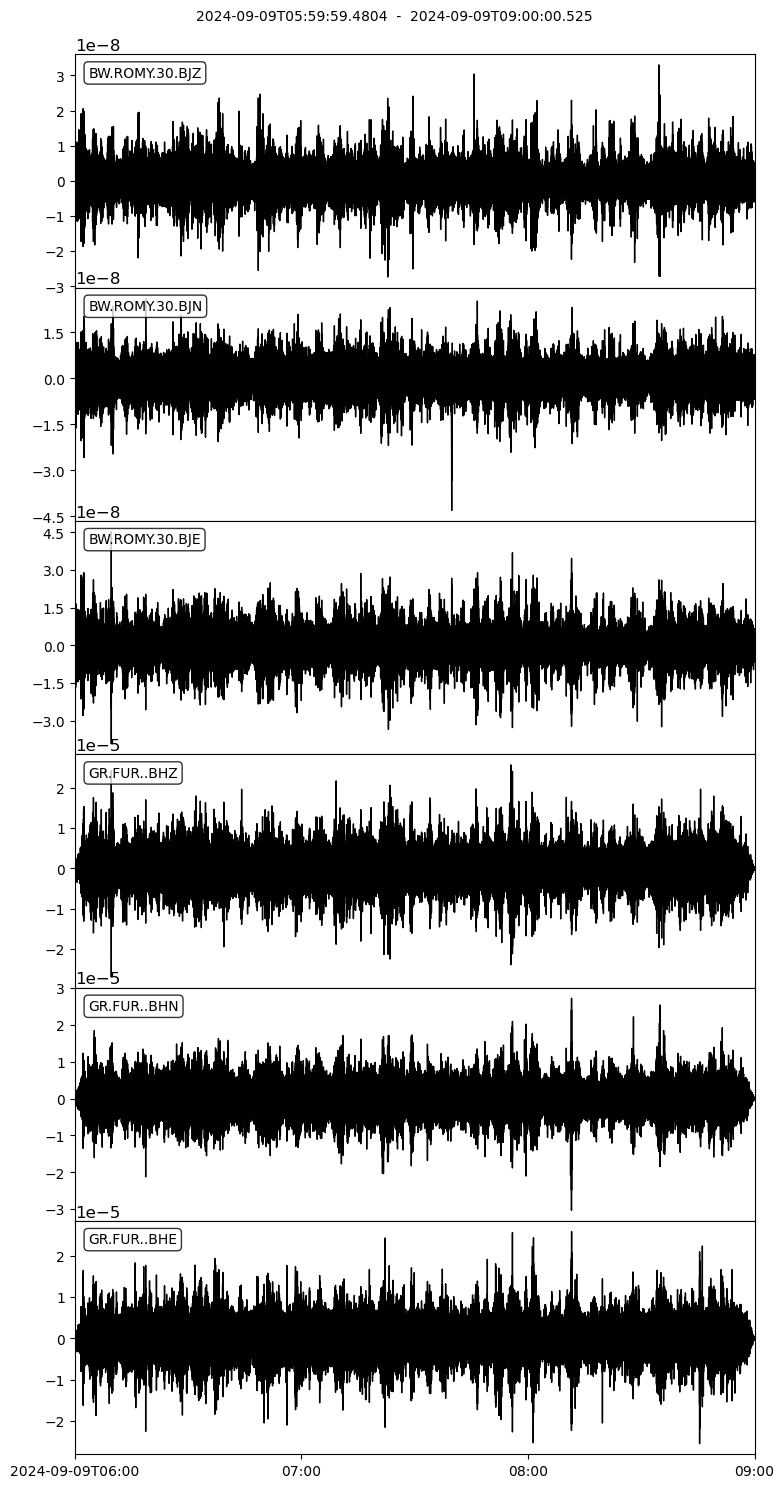

--------------------------------------------------------
ROLODE estimator class:
Parameters:
  highpass frequencies:
    [5.62341325 3.98107171 2.81838293 1.99526231 1.41253754 1.
 0.70794578 0.50118723 0.35481339 0.25118864 0.17782794 0.12589254
 0.08912509 0.06309573 0.04466836 0.03162278 0.02238721 0.01584893
 0.01122018]
  lowpass frequencies:
    [7.94328235 5.62341325 3.98107171 2.81838293 1.99526231 1.41253754
 1.         0.70794578 0.50118723 0.35481339 0.25118864 0.17782794
 0.12589254 0.08912509 0.06309573 0.04466836 0.03162278 0.02238721
 0.01584893]
  periods per window: 8.00
--------------------------------------------------------

ROLODE parameter estimation for seperate time windows

  from: Mon Sep  9 05:59:59 2024
  to:   Mon Sep  9 09:00:00 2024

  Now at frequency f = 6.69 with bandwidth df = 2.32
  Now at frequency f = 4.73 with bandwidth df = 1.64
  Now at frequency f = 3.35 with bandwidth df = 1.16
  Now at frequency f = 2.37 with bandwidth df = 0.82
  Now at freq

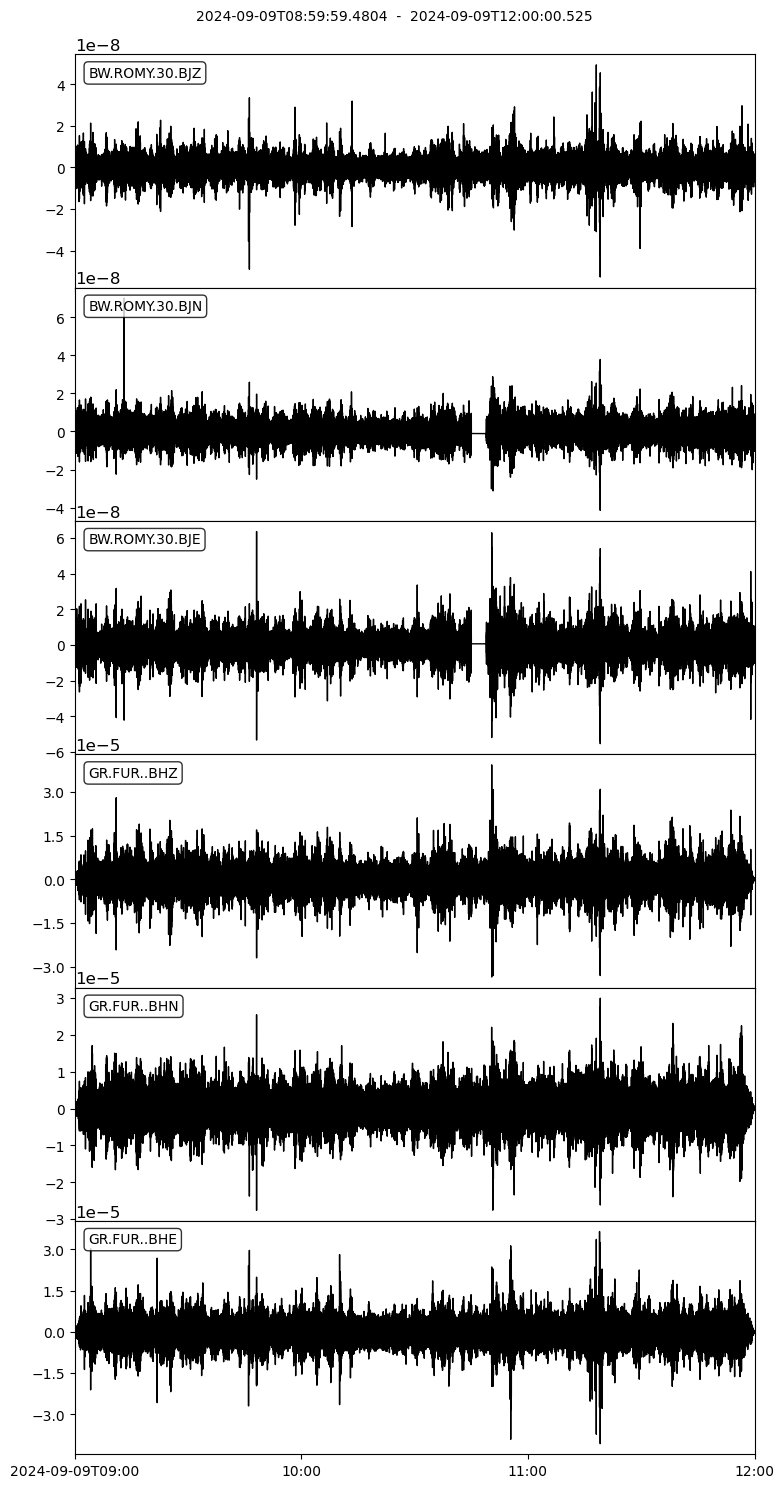

--------------------------------------------------------
ROLODE estimator class:
Parameters:
  highpass frequencies:
    [5.62341325 3.98107171 2.81838293 1.99526231 1.41253754 1.
 0.70794578 0.50118723 0.35481339 0.25118864 0.17782794 0.12589254
 0.08912509 0.06309573 0.04466836 0.03162278 0.02238721 0.01584893
 0.01122018]
  lowpass frequencies:
    [7.94328235 5.62341325 3.98107171 2.81838293 1.99526231 1.41253754
 1.         0.70794578 0.50118723 0.35481339 0.25118864 0.17782794
 0.12589254 0.08912509 0.06309573 0.04466836 0.03162278 0.02238721
 0.01584893]
  periods per window: 8.00
--------------------------------------------------------

ROLODE parameter estimation for seperate time windows

  from: Mon Sep  9 08:59:59 2024
  to:   Mon Sep  9 12:00:00 2024

  Now at frequency f = 6.69 with bandwidth df = 2.32
  Now at frequency f = 4.73 with bandwidth df = 1.64
  Now at frequency f = 3.35 with bandwidth df = 1.16
  Now at frequency f = 2.37 with bandwidth df = 0.82
  Now at freq

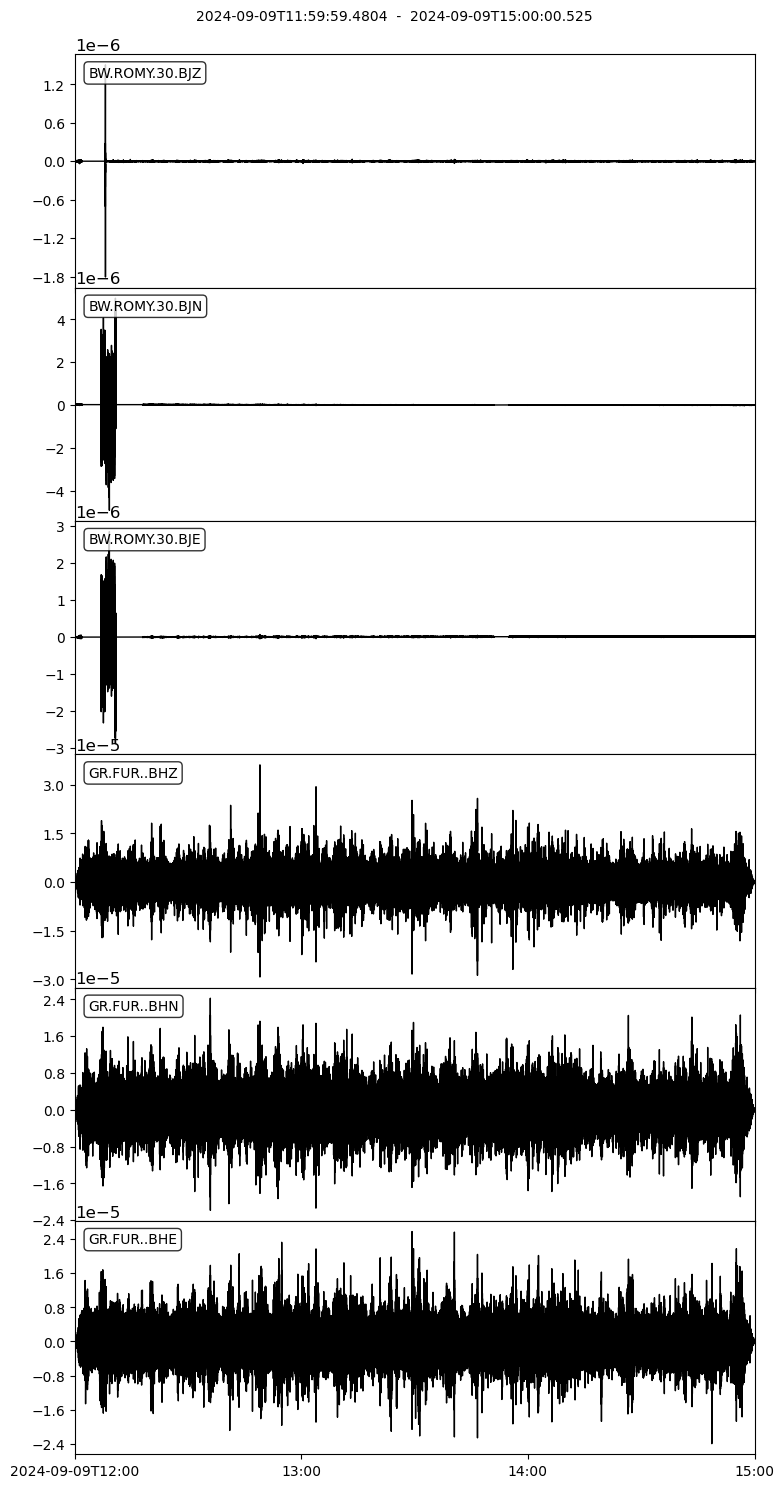

--------------------------------------------------------
ROLODE estimator class:
Parameters:
  highpass frequencies:
    [5.62341325 3.98107171 2.81838293 1.99526231 1.41253754 1.
 0.70794578 0.50118723 0.35481339 0.25118864 0.17782794 0.12589254
 0.08912509 0.06309573 0.04466836 0.03162278 0.02238721 0.01584893
 0.01122018]
  lowpass frequencies:
    [7.94328235 5.62341325 3.98107171 2.81838293 1.99526231 1.41253754
 1.         0.70794578 0.50118723 0.35481339 0.25118864 0.17782794
 0.12589254 0.08912509 0.06309573 0.04466836 0.03162278 0.02238721
 0.01584893]
  periods per window: 8.00
--------------------------------------------------------

ROLODE parameter estimation for seperate time windows

  from: Mon Sep  9 11:59:59 2024
  to:   Mon Sep  9 15:00:00 2024

  Now at frequency f = 6.69 with bandwidth df = 2.32
  Now at frequency f = 4.73 with bandwidth df = 1.64
  Now at frequency f = 3.35 with bandwidth df = 1.16
  Now at frequency f = 2.37 with bandwidth df = 0.82
  Now at freq

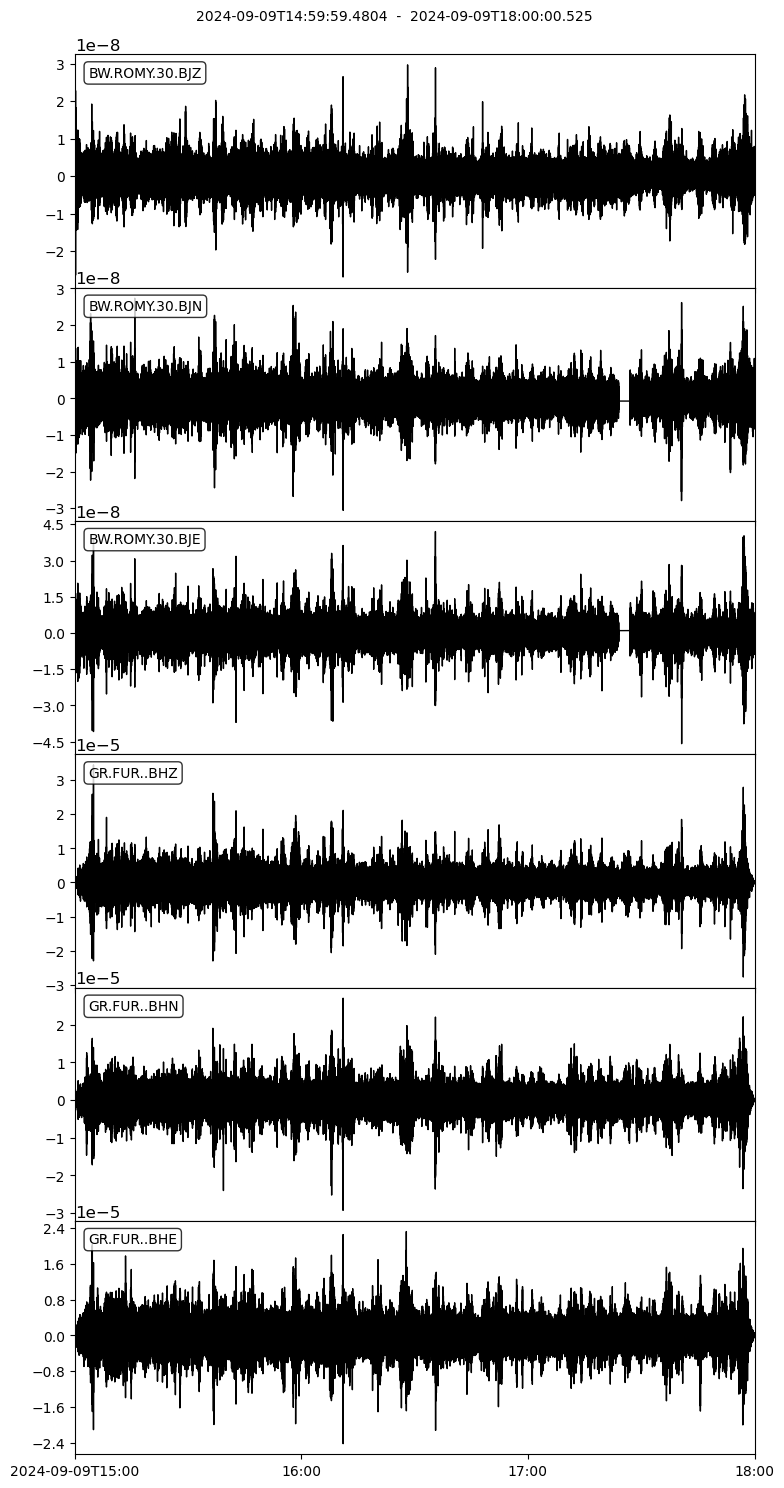

--------------------------------------------------------
ROLODE estimator class:
Parameters:
  highpass frequencies:
    [5.62341325 3.98107171 2.81838293 1.99526231 1.41253754 1.
 0.70794578 0.50118723 0.35481339 0.25118864 0.17782794 0.12589254
 0.08912509 0.06309573 0.04466836 0.03162278 0.02238721 0.01584893
 0.01122018]
  lowpass frequencies:
    [7.94328235 5.62341325 3.98107171 2.81838293 1.99526231 1.41253754
 1.         0.70794578 0.50118723 0.35481339 0.25118864 0.17782794
 0.12589254 0.08912509 0.06309573 0.04466836 0.03162278 0.02238721
 0.01584893]
  periods per window: 8.00
--------------------------------------------------------

ROLODE parameter estimation for seperate time windows

  from: Mon Sep  9 14:59:59 2024
  to:   Mon Sep  9 18:00:00 2024

  Now at frequency f = 6.69 with bandwidth df = 2.32
  Now at frequency f = 4.73 with bandwidth df = 1.64
  Now at frequency f = 3.35 with bandwidth df = 1.16
  Now at frequency f = 2.37 with bandwidth df = 0.82
  Now at freq

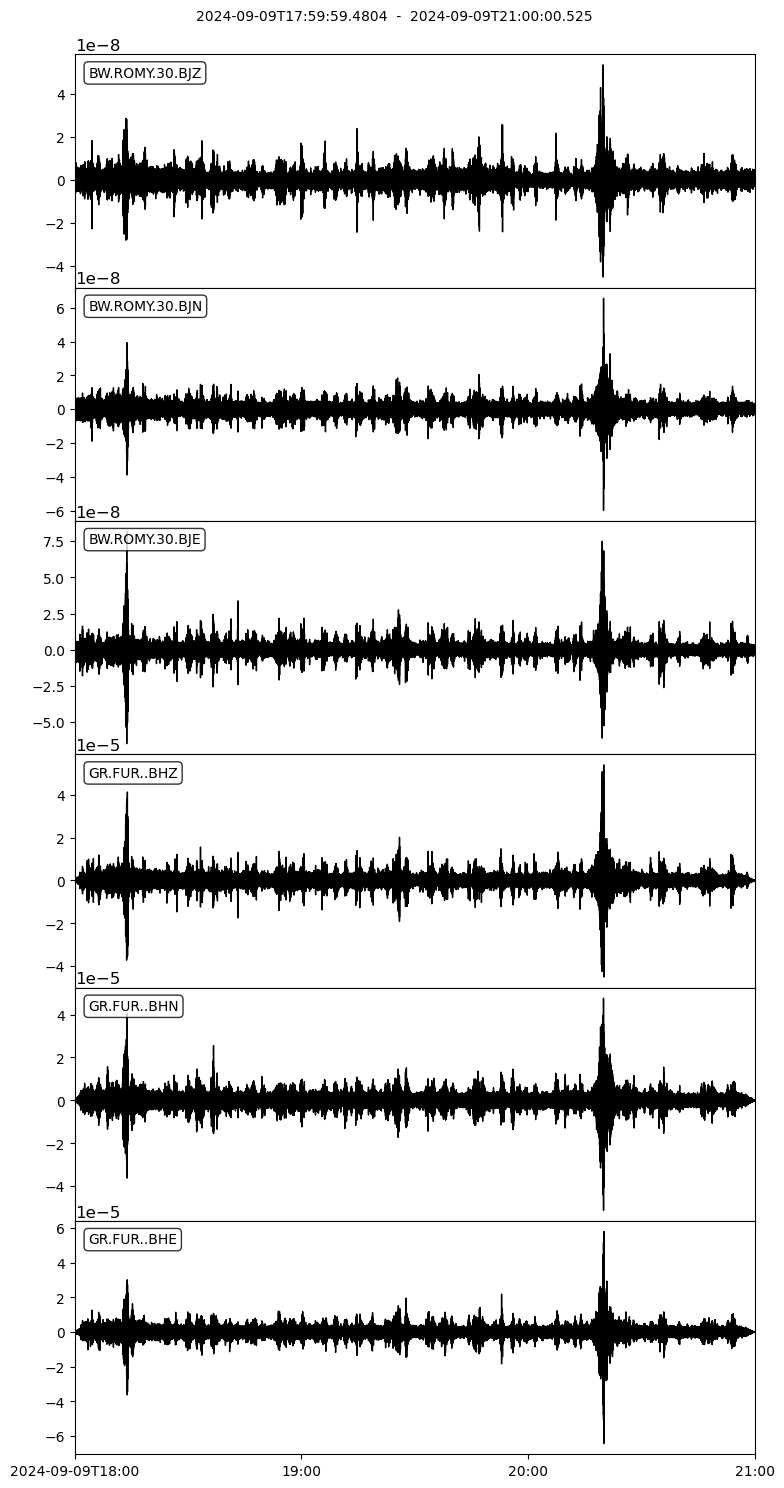

--------------------------------------------------------
ROLODE estimator class:
Parameters:
  highpass frequencies:
    [5.62341325 3.98107171 2.81838293 1.99526231 1.41253754 1.
 0.70794578 0.50118723 0.35481339 0.25118864 0.17782794 0.12589254
 0.08912509 0.06309573 0.04466836 0.03162278 0.02238721 0.01584893
 0.01122018]
  lowpass frequencies:
    [7.94328235 5.62341325 3.98107171 2.81838293 1.99526231 1.41253754
 1.         0.70794578 0.50118723 0.35481339 0.25118864 0.17782794
 0.12589254 0.08912509 0.06309573 0.04466836 0.03162278 0.02238721
 0.01584893]
  periods per window: 8.00
--------------------------------------------------------

ROLODE parameter estimation for seperate time windows

  from: Mon Sep  9 17:59:59 2024
  to:   Mon Sep  9 21:00:00 2024

  Now at frequency f = 6.69 with bandwidth df = 2.32
  Now at frequency f = 4.73 with bandwidth df = 1.64
  Now at frequency f = 3.35 with bandwidth df = 1.16
  Now at frequency f = 2.37 with bandwidth df = 0.82
  Now at freq

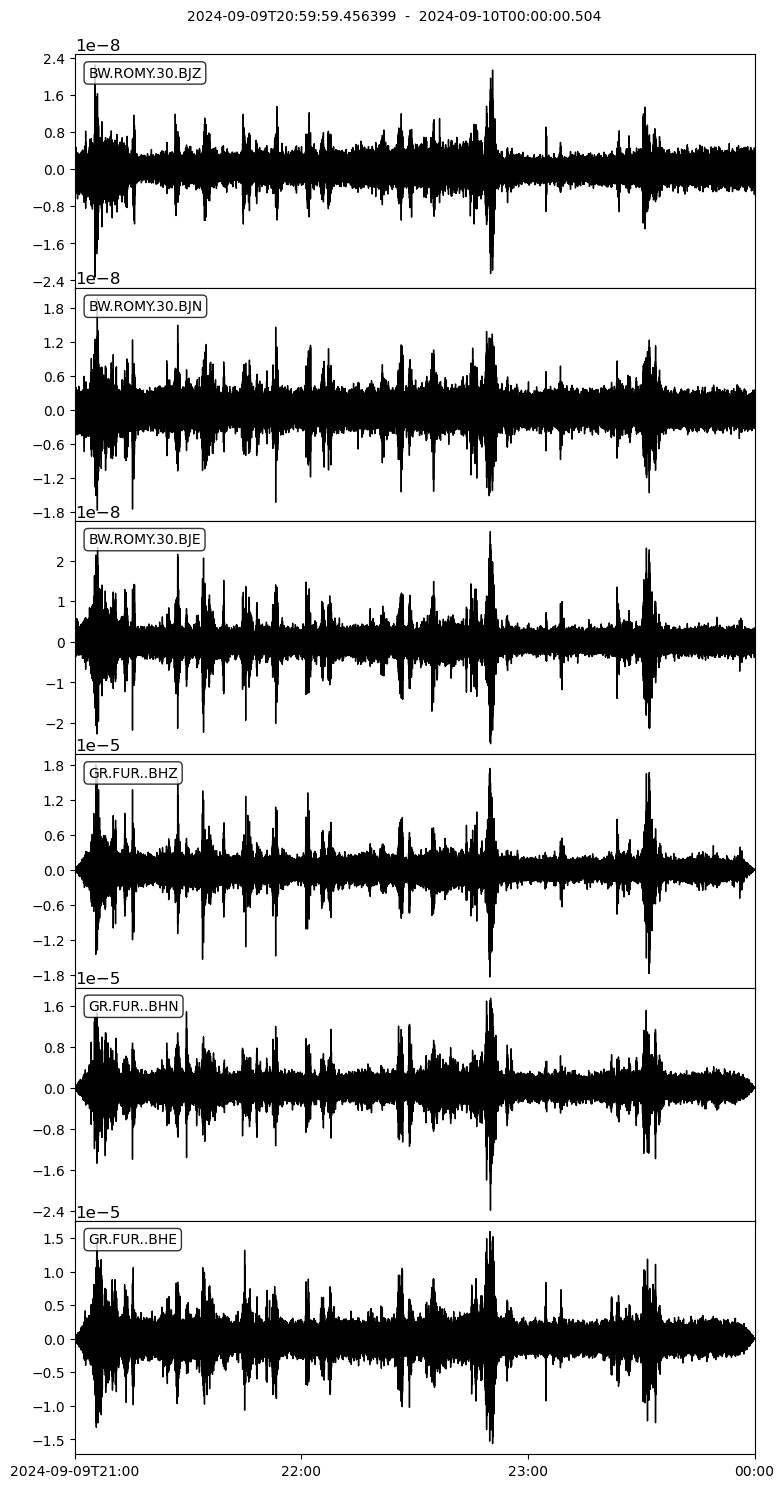

--------------------------------------------------------
ROLODE estimator class:
Parameters:
  highpass frequencies:
    [5.62341325 3.98107171 2.81838293 1.99526231 1.41253754 1.
 0.70794578 0.50118723 0.35481339 0.25118864 0.17782794 0.12589254
 0.08912509 0.06309573 0.04466836 0.03162278 0.02238721 0.01584893
 0.01122018]
  lowpass frequencies:
    [7.94328235 5.62341325 3.98107171 2.81838293 1.99526231 1.41253754
 1.         0.70794578 0.50118723 0.35481339 0.25118864 0.17782794
 0.12589254 0.08912509 0.06309573 0.04466836 0.03162278 0.02238721
 0.01584893]
  periods per window: 8.00
--------------------------------------------------------

ROLODE parameter estimation for seperate time windows

  from: Mon Sep  9 20:59:59 2024
  to:   Tue Sep 10 00:00:00 2024

  Now at frequency f = 6.69 with bandwidth df = 2.32
  Now at frequency f = 4.73 with bandwidth df = 1.64
  Now at frequency f = 3.35 with bandwidth df = 1.16
  Now at frequency f = 2.37 with bandwidth df = 0.82
  Now at freq

/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/andbro/notebooks/VelocityChanges/rochade_v3.py:732: UserWarning: Not able to calculate kde ... continuing
  warnings.warn(msg)
/home/andbro/notebooks/VelocityChanges/rochade_v3.py:1048: UserWarning: Nothing to plot...
  warnings.warn(msg)
/home/andbro/notebooks/VelocityChanges/rochade_v3.py:817: RuntimeWarning: divide by zero encountered in divide
  color=cmap(row / hist.max()),linewidth=0)
/home/andbro/notebooks/VelocityChanges/rochade_v3.py:817

Plotting Dispersion curve with errorbars

 Done for RAYLEIGH2



In [11]:
def main(config):

    stop = False

    # ____________________________________________

    # get octave bands
    f_lower, f_higher, f_center = __get_octave_bands(config['f_min'],
                                                     config['f_max'],
                                                     faction_of_octave=config['faction_of_octave'],
                                                     plot=False
                                                    )

    # cut first and last
    f_lower, f_higher = f_lower[1:-1], f_higher[1:-1]

#     f_lower = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
#     f_higher = np.array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

    # reverse sorting
    f_lower, f_higher = f_lower[::-1], f_higher[::-1]

    # ____________________________________________

    # pre-calculate time intervals for loop based on starttime, endtime and specified time intervals
    times = __get_time_intervals(config['tbeg'],
                                 config['tend'],
                                 config['interval_seconds'],
                                 config['interval_overlap']
                                )

    # ____________________________________________
    # run loop

    for t1, t2 in tqdm(times):

        tsz = []
        tsn = []
        tse = []
        coo = []
        first = True

        # ____________________________________________
        # load inventory data
        try:
            config['rot_inv'] = read_inventory(config['path_to_inv_rot'])
            config['tra_inv'] = read_inventory(config['path_to_inv_tra'])
        except:
            print(f" -> loading inventories failed!")

        st = Stream()

        # ____________________________________________
        # load rotational data
        st += __load_rot_data(config, t1, t2)

        # ____________________________________________
        # load translational data
        st += __load_tra_data(config, t1, t2)

        # ____________________________________________
        # pre-processing

        # check if stream has correct length
        if len(st) < 6:
            print(f" -> missing stream data")

        # check if merging is required
        if len(st) > 6:
            st = st.merge(method=1, fill_value=0)

        st = st.detrend("linear")

        st = st.trim(t1-.5, t2+.5)

        # check for same sample size
        # st = st._rtim()
        print(st)

        # check if all traces have same amount of samples
        n_samples = [tr.stats.npts for tr in st]
        if not all(x == n_samples[0] for x in n_samples):
            print(f" -> stream size inconsistent: {n_samples}")

            # if difference not larger than one -> adjust
            if any([abs(x-n_samples[0]) > 1 for x in n_samples]):
                stop = True
            else:
                for tr in st:
                    tr.data = tr.data[:min(n_samples)]

        if stop:
            continue

        st.plot(equal_scale=False);

        rot = st.select(channel="*J*")
        acc = st.select(channel="*H*")

        ###################################################################
        # Start of calculations ...
        ###################################################################

        # define filename
        name = f"ROMY_{config['tbeg'].date}_{config['tend'].date}"

        # store in config
        config['filename'] = name

        ####################################################################
        # LOVE WAVES
        # Main processing step, window_estimation takes the
        # vertical rotation rate, north acceleration and east acceleration
        # and calculates the estimations
        # LOVE WAVES
        ####################################################################

        if config['love_waves']:

            # and the parameter periods_per_window
            windows_l = rochade.rolode_estimator(f_lower=f_lower, f_higher=f_higher,
                                                 periods_per_window=config['periods_per_window'],
                                                 v_min=config['vmin'],
                                                 v_max=config['vmax'],
                                                 trigger_params=config['trigger_params'],
                                                )

            if config['verbose']:
                windows_l.printlog()

            if config['body']:

                irot = rot.copy()
                irot.integrate()
                print(irot)

                windows_l.window_estimation_love(irot.select(component="Z")[0],
                                                 acc.select(component="N")[0],
                                                 acc.select(component="E")[0],
                                                 mask_value=config['mvalue'],
                                                 body=config['body'],
                                                 trigger=config['detrigger'],
                                                 verbose=config['verbose'],
                                                )

                # define path where to save output:
                save_path_love = config['path_to_outdata']+f"ROLODE/VROMY_HH/{name}-SV/"

            else:
                windows_l.window_estimation_love(rot.select(component="Z")[0],
                                                 acc.select(component="N")[0],
                                                 acc.select(component="E")[0],
                                                 mask_value=config['mvalue'],
                                                 trigger=config['detrigger'],
                                                 verbose=config['verbose'],
                                                )

                save_path_love = config['path_to_outdata']+f"ROLODE/VROMY_HH/{name}-Love/"

            # createt directories
            if not os.path.exists(save_path_love):
                os.makedirs(save_path_love)

            # write to file and log
            windows_l.write(save_path_love+"windows_l.pkl", config['firstRun'])
            windows_l.writelog(save_path_love+"info_l.log", config['firstRun'])

            config['save_path_love'] = save_path_love


        ###################################################################
        # RAYLEIGH WAVES
        # Main processing step, window_estimation takes the
        # vertical acceleration, north and east rotation rate
        # and calculates the estimations
        # RAYLEIGH WAVES
        ###################################################################

        if config['rayleigh1_waves']:

            windows_r = rochade.rolode_estimator(f_lower=f_lower, f_higher=f_higher,
                                                 periods_per_window=config['periods_per_window'],
                                                 v_min=config['vmin'],
                                                 v_max=config['vmax'],
                                                 trigger_params=config['trigger_params'],
                                                )
            if config['verbose']:
                windows_r.printlog()

            if config['body']:
                irot = rot.copy()
                irot.integrate()

                windows_r.window_estimation_rayleigh(acc.select(component="Z")[0],
                                                     irot.select(component="N")[0],
                                                     irot.select(component="E")[0],
                                                     mask_value=config['mvalue'],
                                                     body=config['body'],
                                                     trigger=config['detrigger'],
                                                     verbose=config['verbose'],
                                                    )

                save_path_ray1 = config['path_to_outdata']+f"ROLODE/VROMY_HH/{name}-SV1/"
            else:

                windows_r.window_estimation_rayleigh(acc.select(component="Z")[0],
                                                     rot.select(component="N")[0],
                                                     rot.select(component="E")[0],
                                                     mask_value=config['mvalue'],
                                                     trigger=config['detrigger'],
                                                     verbose=config['verbose'],
                                                    )

                save_path_ray1 = config['path_to_outdata']+f"ROLODE/VROMY_HH/{name}-Rayleigh/"

            # createt directories
            if not os.path.exists(save_path_ray1):
                os.makedirs(save_path_ray1)

            # write to file and log
            windows_r.write(save_path_ray1+"windows_r.pkl", config['firstRun'])
            windows_r.writelog(save_path_ray1+"info_r.log", config['firstRun'])

            config['save_path_rayleigh1'] = save_path_ray1

        ##################################################################
        # RAYLEIGH WAVES
        # Main processing step, window_estimation takes the
        # vertical acceleration, north and east rotation rate
        # and calculates the estimations
        # RAYLEIGH WAVES
        ###################################################################

        if config['rayleigh2_waves']:

            windows_r2 = rochade.rolode_estimator(f_lower=f_lower, f_higher=f_higher,
                                                 periods_per_window=config['periods_per_window'],
                                                 v_min=config['vmin'],
                                                 v_max=config['vmax'],
                                                 trigger_params=config['trigger_params'],
                                                )

            if config['verbose']:
                windows_r2.printlog()

            if config['body']:
                irot = rot.copy()
                irot.integrate()

                save_path_ray2 = config['path_to_outdata']+f"ROLODE/VROMY_HH/{name}-SV2/"

                windows_r2.window_estimation_rayleigh2(acc,
                                                       irot.select(component="N")[0],
                                                       irot.select(component="E")[0],
                                                       body=config['body'],
                                                       mask_value=config['mvalue'],
                                                       trigger=config['detrigger'],
                                                       verbose=config['verbose'],
                                                      )

            else:

                save_path_ray2 = config['path_to_outdata']+f"ROLODE/VROMY_HH/{name}-Rayleigh2/"

                windows_r2.window_estimation_rayleigh2(acc,
                                                       rot.select(component="N")[0],
                                                       rot.select(component="E")[0],
                                                       body=config['body'],
                                                       mask_value=config['mvalue'],
                                                       trigger=config['detrigger'],
                                                       verbose=config['verbose'],
                                                      )

            # createt directories
            if not os.path.exists(save_path_ray2):
                os.makedirs(save_path_ray2)

            # write to file and log
            windows_r2.write(save_path_ray2+"windows_r2.pkl", config['firstRun'])
            windows_r2.writelog(save_path_ray2+"info_r2.log", config['firstRun'])

            config['save_path_rayleigh2'] = save_path_ray2

        config['firstRun'] = False

    ###################################################################
    # Postprocessing
    ##################################################################

    if config['love_waves']:

        __postprocessing(config, wave_type="love")

    if config['rayleigh1_waves']:

        __postprocessing(config, wave_type="rayleigh1")

    if config['rayleigh2_waves']:

        __postprocessing(config, wave_type="rayleigh2")

    # ____________________________________________
    # store configurations
#     config_dump = config

#     config_dump['tbeg'] = str(config_dump['tbeg'])
#     config_dump['tend'] = str(config_dump['tend'])

#     # store configurations
#     with open(config['path_to_sds']+f"{config['filename']}_config.yml", "w") as outfile:
#         yaml.dump(config, outfile, default_flow_style=False, sort_keys=True)


# if __name__ == "__main__":
#     main(config)

main(config)